In [1]:
import sys
import time
import os
import random
import keras
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F 
import torchvision.utils as utils
import cv2 
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
from google.colab.patches import cv2_imshow
import matplotlib.cbook as cbook
import matplotlib.image as image


In [2]:
f = 3
C = 3

h = 225
l = 225

h_ = h-3+1;
l_ = l-3+1;

snapea_count = 0
original_count = 0
proposed_algo_count = 0

random.seed(10)
X = 2*np.random.randn(h,l)-1
W = np.random.randn(f,f)

def Sort_Tuple(tup):
    tup.sort(key = lambda x:x[2])
    return tup

def Sort_Tuple_Reverse(tup):
    tup.sort(key = lambda x:x[2], reverse=True)
    return tup

In [3]:
weights = []

for l1 in range(f):
    for l2 in range(f):
        weights.append((l1, l2, W[l1][l2]))

weights = Sort_Tuple(weights)

print(weights)

[(2, 2, -0.8898666931376399), (0, 1, -0.8501585212362337), (0, 2, -0.097505541600873), (1, 2, 0.17504890243081472), (1, 1, 0.3267431226449127), (2, 0, 0.6051182853732857), (1, 0, 0.8500549082395328), (0, 0, 0.9979051314179025), (2, 1, 1.0787830897719828)]


SnaPEA Exact Mode

In [4]:
SnaPEA = np.zeros((h_,l_))
for i in range(0,h_):
    for j in range(0,l_):
        for iter in range(len(weights)):
                SnaPEA[i][j]+=(X[i+weights[iter][0]][j+weights[iter][1]]*weights[iter][2])
                snapea_count+=1
                if SnaPEA[i][j]<0:
                   SnaPEA[i][j]=0
                   break

Proposed Algorithm

In [5]:
K = 3

min_ = -2
max_ = 2
for r in range(f):
    for c in range(f):
        if min_ > W[r][c]:
           min_ = W[r][c]
        if max_ < W[r][c]:
           max_ = W[r][c]

centroids = []
centroids.append(min_)
centroids.append((min_+max_)/2)
centroids.append(max_)

#print(centroids)

assigns = np.zeros([3,3],dtype = int)

for i in range(10):
    for r in range(f):
        for c in range(f):
            index=0
            dist=2
            for iter in range(f):
                if dist > abs(centroids[iter]-W[r][c]):
                  dist = abs(centroids[iter]-W[r][c])
                  index = iter
            assigns[r][c]=index
    new_centroids = [0,0,0]
    counts = [0,0,0]
    for r in range(f):
        for c in range(f):
            new_centroids[assigns[r][c]]+=W[r][c];
            counts[assigns[r][c]]+=1
    for ind in range(3):
        if counts[ind]!=0:
           new_centroids[ind]/=counts[ind]
        else:
           new_centroids[ind] = centroids[ind]
    centroids = new_centroids

print(assigns)
print("Centroids \n")
print(centroids)

[[2 1 1]
 [2 2 1]
 [2 2 1]]
Centroids 

[-2, -0.41562046338598296, 0.7717209074895233]


In [6]:
Prop = np.zeros((h_,l_))
for i in range(0,h_,1):
    for j in range(0,l_,1):
        partial_sum = [0,0,0]
        for r in range(f):
            for c in range(f):
                partial_sum[assigns[r][c]]+=X[i+r][j+c]
                # print(partial_sum)
        sum = 0
        for iter in range(3):
            sum+= partial_sum[iter]*centroids[iter]        
            proposed_algo_count += 1
        # print(sum)
        if sum<0: 
           Prop[i][j] = 0
        else:
           Prop[i][j] = sum

Original 

In [7]:
Orig = np.zeros((h_,l_))
for i in range(0,h_):
    for j in range(0,l_):
        for r in range(f):
            for c in range(f):
                Orig[i][j]+=(X[i+r][j+c]*W[r][c])
                original_count+= 1
        if Orig[i][j]<0:
            Orig[i][j]=0
       
S_TP = 0
S_TN = 0
S_FP = 0
S_FN = 0

Pr_TP = 0
Pr_TN = 0
Pr_FP = 0
Pr_FN = 0

for i in range(0,h_):
    for j in range(0,l_):
        if Orig[i][j]==0:
          if SnaPEA[i][j]==0:
             S_TP += 1
          if SnaPEA[i][j]>0:
             S_FP += 1
          if Prop[i][j]==0:
             Pr_TP += 1
          if Prop[i][j]>0:
             Pr_FP += 1
        else:
          if SnaPEA[i][j]>0:
             S_TN += 1
          if SnaPEA[i][j]==0:
             S_FN += 1
          if Prop[i][j]>0:
             Pr_TN += 1
          if Prop[i][j]==0:
             Pr_FN += 1

Original


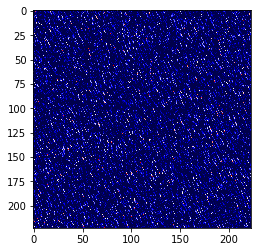

Proposed


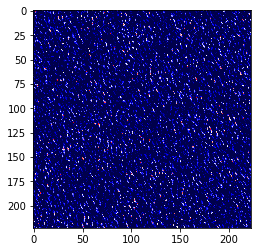

SnaPEA


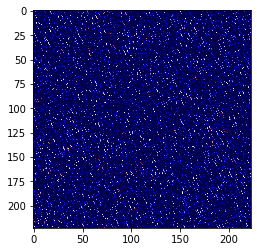

In [8]:
print("Original")
plt.imshow(Orig, cmap='seismic', interpolation='nearest')
plt.show()
print("Proposed")
plt.imshow(Prop, cmap='seismic', interpolation='nearest')
plt.show()
print("SnaPEA")
plt.imshow(SnaPEA, cmap='seismic', interpolation='nearest')
plt.show()

In [9]:
print("Snapea: ", snapea_count)
print("Proposed Algorithm: ", proposed_algo_count)
print("Original count: ", original_count)

Snapea:  261604
Proposed Algorithm:  149187
Original count:  447561


In [10]:
snapea_precision = S_TP/(S_TP + S_FP)
snapea_recall = S_TP/(S_TP + S_FN)

prop_precision = Pr_TP/(Pr_TP + Pr_FP)
prop_recall = Pr_TP/(Pr_TP + Pr_FN)

print("Snapea Precision : ", snapea_precision)
print("Snapea Recall : ", snapea_recall)

print("Proposed Algorithm Precision: ", prop_precision)
print("Proposed Algorithm Recall: ", prop_recall)

S_F1 = 2*(snapea_recall*snapea_precision)/(snapea_precision+snapea_recall)
Pr_F1 = 2*(prop_recall*prop_precision)/(prop_precision+prop_recall)

print("Snapea F1 Score: ", S_F1)
print("Proposed Algorithm F1 Score: ", Pr_F1)

Snapea Precision :  1.0
Snapea Recall :  0.8675904346944979
Proposed Algorithm Precision:  0.9148880259277643
Proposed Algorithm Recall:  0.8793534083574215
Snapea F1 Score:  0.9291013903017972
Proposed Algorithm F1 Score:  0.8967688388998598
